# Distance Metric Analysis: Hamming vs Edit Distance for CRISPR Spacer Detection

## Overview

This notebook quantifies how distance metric choice affects spurious match rates using simulated CRISPR spacer data with ground truth. We compare:
- **Hamming Distance** (≤N): Substitutions only, no indels allowed
- **Edit Distance** (≤N): Substitutions + indels allowed

We use the `compare-results` command which implements:
- **Coordinate tolerance matching** (5bp default) to handle slight boundary differences (e.g., placing a gap instead of a substitution in the terminal region of an alignment)
- **Verification**: All reported alignments (including those not in the ground truth) are verified by extracting the reference region and aligning to the reported spacer sequence
- **Classification into three categories**:
  - `positive_in_plan`: Matches ground truth (true positives)
  - `positive_not_in_plan`: Valid alignment NOT in ground truth (spurious/chance matches, or real matches when no GT exists)
  - `invalid_alignment`: **True False Positives** - failed verification (exceeds distance threshold)
- **Augmented metrics**: For simulated runs, adjusts metrics to include verified non-planned alignments as true positives

## Important Terminology:

**What are "False Positives" in this analysis?**
- **Invalid alignments** = True false positives (alignments that fail validation - the distance measured is larger than the accepeted thershold). Note, some tools don't really let us control setting a thershold, so some level of these is accepted.
- **Positives not in plan** ≠ False positives! These are:
  - Valid alignments that arise by chance (spurious matches)
  - Real biological matches (when there is no ground truth)
  - We mostly **ignore invalid alignments** in these plots and focus on spurious match rates

**Metrics:**
- **TP_planned**: Planned spacers correctly identified
- **GT_planned**: Simulated ground truth (where/how we inserted spacers)
- **All_TP**: TP_planned + verified non-planned
- **GT_augmented**: GT_planned + verified non-planned
- **Invalid alignments**: Alignments that failed verification (true FPs)

**Performance Metrics:**
- **Precision (planned)**: TP_planned / (TP_planned + all non-TP)
- **Recall (planned)**: TP_planned / GT_planned
- **Precision (augmented)**: All_TP / (All_TP + invalid_alignments)
- **Recall (augmented)**: All_TP / GT_augmented
- **Spurious Rate**: (positives_not_in_plan / all valid alignments) × 100
- **Invalid Rate**: (invalid_alignments / all alignments) × 100

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
# import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import glob 

# Configuration
MAX_MISMATCHES_RANGE = [0, 1, 2, 3, 4, 5]

def run_compare_results(sim_dir, max_mismatches, distance_metric='hamming', verbose=False, logfile=None):
    """
    Run compare-results command for a simulation directory.
    
    Args:
        sim_dir: Path to simulation directory
        max_mismatches: Maximum allowed mismatches
        distance_metric: 'hamming' or 'edit'
        verbose: Whether to run in verbose mode (DEBUG logging to console)
        logfile: Optional path to logfile for DEBUG output (always DEBUG level, independent of --verbose)
        
    Returns:
        Path to performance_results_{distance_metric}_mm{max_mismatches}.tsv file
        
    Note:
        - Verbose flag enables DEBUG logging to console (shows operational details)
        - Logfile always captures DEBUG level regardless of verbose flag
        - With recent updates, operational print() statements converted to logger.debug()
          so clean output in notebooks without verbose, detailed logs in logfile
    """
    cmd = [
        'pixi', 'run', 'spacer_bencher',
        'compare-results',
        '--input-dir', str(sim_dir),
        '-mm', str(max_mismatches),
        '--distance', distance_metric,
        '--threads', '4',
        "--skip-hyperfine"
    ]
    
    if verbose:
        cmd.insert(3, '--verbose')
    
    if logfile:
        cmd.extend(['--logfile', str(logfile)])
    
    print(f"Running: {' '.join(cmd)}")
    # Don't capture output so user can see important messages
    result = subprocess.run(cmd)
    
    if result.returncode != 0:
        print("Error running compare-results!")
        if logfile:
            print(f"Check logfile for details: {logfile}")
        return None
    
    # Performance results are saved with distance metric and threshold in filename
    perf_file = Path(sim_dir) / f'performance_results_{distance_metric}_mm{max_mismatches}.tsv'
    
    if not perf_file.exists():
        print(f"Performance results not found: {perf_file}")
        return None
    
    return perf_file

def load_performance_results(sim_dir, distance_metric='hamming', max_mismatches=3):
    """Load performance results TSV file for specific metric and threshold."""
    perf_file = Path(sim_dir) / f'performance_results_{distance_metric}_mm{max_mismatches}.tsv'
    if not perf_file.exists():
        print(f"Performance results not found: {perf_file}")
        return None
    
    return pl.read_csv(str(perf_file), separator='\t')

def analyze_simulation_threshold_sweep(sim_dir, distance_metric='hamming', thresholds=None, verbose=False, logfile_dir=None):
    """
    Run compare-results for multiple thresholds and aggregate metrics across ALL tools.
    
    Args:
        sim_dir: Path to simulation directory
        distance_metric: 'hamming' or 'edit'
        thresholds: List of thresholds to test (default: 0-5)
        verbose: Whether to show verbose output (DEBUG to console)
        logfile_dir: Optional directory for logfiles (always DEBUG level)
        
    Returns:
        DataFrame with aggregated metrics for each threshold (combined across all tools)
    """
    if thresholds is None:
        thresholds = MAX_MISMATCHES_RANGE
    
    results = []
    
    for threshold in thresholds:
        print(f"\nAnalyzing {distance_metric} distance with threshold ≤ {threshold}...")
        
        # Setup logfile if requested
        logfile = None
        if logfile_dir:
            Path(logfile_dir).mkdir(parents=True, exist_ok=True)
            logfile = Path(logfile_dir) / f"compare_{distance_metric}_mm{threshold}.log"
        
        # Run compare-results
        perf_file = run_compare_results(sim_dir, threshold, distance_metric, verbose=verbose, logfile=logfile)
        
        if perf_file is None or not perf_file.exists():
            print(f"Skipping threshold {threshold} - no results")
            continue
        
        # Load results
        perf_df = pl.read_csv(str(perf_file), separator='\t')
        
        # Aggregate across ALL tools
        total_planned_tp = perf_df['planned_true_positives'].sum()
        total_all_tp = perf_df['all_true_positives'].sum()
        total_non_planned = perf_df['positives_not_in_plan'].sum()
        total_invalid = perf_df['invalid_alignments'].sum()
        total_fn_planned = perf_df['false_negatives_planned'].sum()
        
        # Get ground truth counts (should be same across all tools)
        gt_planned = perf_df['ground_truth_planned'][0] if perf_df.height > 0 else 0
        gt_augmented = perf_df['ground_truth_augmented'][0] if perf_df.height > 0 else 0
        
        # Calculate aggregate metrics
        recall_planned = total_planned_tp / gt_planned if gt_planned > 0 else None
        recall_augmented = total_all_tp / gt_augmented if gt_augmented > 0 else None
        
        total_alignments = total_all_tp + total_invalid
        precision_augmented = total_all_tp / total_alignments if total_alignments > 0 else None
        
        spurious_pct = (total_non_planned / total_all_tp * 100) if total_all_tp > 0 else 0
        invalid_pct = (total_invalid / total_alignments * 100) if total_alignments > 0 else 0
        
        results.append({
            'threshold': threshold,
            'recall_planned': recall_planned,
            'precision_augmented': precision_augmented,
            'recall_augmented': recall_augmented,
            'all_true_positives': total_all_tp,
            'planned_true_positives': total_planned_tp,
            'positives_not_in_plan': total_non_planned,
            'invalid_alignments': total_invalid,
            'false_negatives_planned': total_fn_planned,
            'ground_truth_planned': gt_planned,
            'ground_truth_augmented': gt_augmented,
            'spurious_rate_pct': spurious_pct,
            'invalid_rate_pct': invalid_pct,
            'identified_pct': recall_planned * 100 if recall_planned is not None else 0,
            'missed_pct': (1 - recall_planned) * 100 if recall_planned is not None else 100,
            'num_tools': perf_df.height,  # Track how many tools contributed
        })
    
    return pl.DataFrame(results)


## Comparison Across Different Search Space Sizes

We'll run `compare-results` for each simulation with both hamming and edit distance metrics across different thresholds to see how:
1. Distance metric choice affects spurious match rates (non-planned valid alignments)
2. Search space size (num_spacers × num_contigs) impacts spurious match frequency
3. Invalid alignment rates (true false positives that fail validation)
4. Coordinate tolerance matching improves detection

In [2]:
# Find all simulation folders starting with 'ns_'
simulated_base_dir = "results/simulated"
simulation_dirs = glob.glob(os.path.join(simulated_base_dir, "ns_*"))

def format_num(n):
    if n >= 1000000:
        return f"{n//1000000}M"
    elif n < 1000:
        return f"{n}"
    else:
        return f"{n//1000}k"

# Filter to only include directories with actual simulation data
valid_sim_dirs = []
for sim_dir in simulation_dirs:
    sim_data_dir = Path(sim_dir) / "simulated_data"
    if sim_data_dir.exists():
        gt_file = sim_data_dir / "planned_ground_truth.tsv"
        # Include even if GT is empty (for baseline comparison)
        valid_sim_dirs.append(sim_dir)

sim_prefixes = [os.path.basename(p) for p in valid_sim_dirs]

SIMULATION_NAMES = {}
for prefix in sim_prefixes:
    parts = prefix.split('_')
    if len(parts) >= 4:
        try:
            n_spacers = int(parts[1])
            n_contigs = int(parts[3])
            SIMULATION_NAMES[prefix] = f"{format_num(n_spacers)} spacers, {format_num(n_contigs)} contigs"
        except ValueError:
            # Skip if can't parse numbers (e.g., real_baseline)
            SIMULATION_NAMES[prefix] = prefix

print(f"Found {len(SIMULATION_NAMES)} simulations:")
for prefix, desc in SIMULATION_NAMES.items():
    print(f"  {prefix}: {desc}")

Found 7 simulations:
  ns_100000_nc_10000: 100k spacers, 10k contigs
  ns_100000_nc_20000: 100k spacers, 20k contigs
  ns_3826979_nc_421431_real_baseline: 3M spacers, 421k contigs
  ns_500000_nc_100000: 500k spacers, 100k contigs
  ns_50000_nc_5000: 50k spacers, 5k contigs
  ns_500_nc_5000_HIGH_INSERTION_RATE: 500 spacers, 5k contigs
  ns_75000_nc_5000: 75k spacers, 5k contigs


In [3]:
# Exclude baselines and other special cases if needed
semi_synthetic = SIMULATION_NAMES.pop("ns_3826979_nc_421431_real_baseline", None)
large_simulated = SIMULATION_NAMES.pop("ns_500000_nc_100000", None)
medium_simulated = SIMULATION_NAMES.pop("ns_100000_nc_20000", None)
# SIMULATION_NAMES.pop("ns_1000000_nc_20000_real_baseline", None)  # Uncomment to exclude

print(f"\nAnalyzing {len(SIMULATION_NAMES)} simulations:")
for prefix in SIMULATION_NAMES:
    print(f"  - {prefix}")


Analyzing 4 simulations:
  - ns_100000_nc_10000
  - ns_50000_nc_5000
  - ns_500_nc_5000_HIGH_INSERTION_RATE
  - ns_75000_nc_5000


In [4]:
# Run analysis for each simulation with both distance metrics
comparison_results = []

for sim_prefix in SIMULATION_NAMES.keys():
    sim_dir = f"results/simulated/{sim_prefix}"
    description = SIMULATION_NAMES[sim_prefix]
    
    print(f"\n{'='*80}")
    print(f"Processing: {sim_prefix}")
    print(f"Description: {description}")
    
    # Analyze with Hamming distance
    print("\n--- HAMMING DISTANCE ---")
    hamming_results = analyze_simulation_threshold_sweep(
        sim_dir, 
        distance_metric='hamming',
        thresholds=MAX_MISMATCHES_RANGE,
        verbose=False,
                    logfile_dir= f"{sim_dir}/logs"

    )
    
    # Analyze with Edit distance
    print("\n--- EDIT DISTANCE ---")
    edit_results = analyze_simulation_threshold_sweep(
        sim_dir,
        distance_metric='edit',
        thresholds=MAX_MISMATCHES_RANGE,
        verbose=False,
        logfile_dir= f"{sim_dir}/logs"
    )
    
    comparison_results.append({
        'sim_prefix': sim_prefix,
        'description': description,
        'hamming_results': hamming_results,
        'edit_results': edit_results
    })
    
    print(f"\n✓ Completed {sim_prefix}")
    

print(f"\n\n{'='*80}")
print(f"Analysis complete for {len(comparison_results)} simulations")
print(f"{'='*80}")


Processing: ns_100000_nc_10000
Description: 100k spacers, 10k contigs

--- HAMMING DISTANCE ---

Analyzing hamming distance with threshold ≤ 0...
Running: pixi run spacer_bencher compare-results --input-dir results/simulated/ns_100000_nc_10000 -mm 0 --distance hamming --threads 4 --skip-hyperfine --logfile results/simulated/ns_100000_nc_10000/logs/compare_hamming_mm0.log
[01/29/26 16:55:54] INFO     DEBUG logging enabled to file:                     
                             results/simulated/ns_100000_nc_10000/logs/compare_h
                             amming_mm0.log                                     
[01/29/26 16:55:54] INFO     Comparing tool results in                          
                             results/simulated/ns_100000_nc_10000               
[01/29/26 16:55:54] INFO     Found 11 tool config files                         
[01/29/26 16:55:54] INFO     Successfully loaded 11 tool configurations         
[01/29/26 16:56:03] INFO     Read 544252 total alignment r


Aborted!


KeyboardInterrupt: 

In [ ]:
# data[""].head()

In [ ]:
# # Load data
# data = load_simulation_data(sim_prefix)
# # Calculate distances
# distances_df, sassy_with_dist = calculate_distances_for_alignments(data)
# print(2)


# # Analyze distance metrics
# hamming_df, edit_df = analyze_distance_metrics(
#     data, distances_df, sassy_with_dist, 
#     hamming_thresholds=list(range(MAX_HAMMING + 1)), # Hamming thresholds from 0 to MAX_HAMMING
#     edit_thresholds=list(range(MAX_EDIT + 1)) # same for edit
# )
# print(3)


# comparison_results.append({
#     'sim_prefix': sim_prefix,
#     'description': description,
#     'hamming_df': hamming_df,
#     'edit_df': edit_df
# })

In [ ]:
comparison_results

[{'sim_prefix': 'ns_100000_nc_10000',
  'description': '100k spacers, 10k contigs',
  'hamming_df': shape: (6, 9)
  ┌───────────┬────────┬───────┬───────┬──────────────┬──────────┬─────────┬───────────┬─────────┐
  │ Threshold ┆ TP     ┆ FP    ┆ FN    ┆ Identified % ┆ Missed % ┆ False % ┆ Precision ┆ Recall  │
  │ ---       ┆ ---    ┆ ---   ┆ ---   ┆ ---          ┆ ---      ┆ ---     ┆ ---       ┆ ---     │
  │ i64       ┆ i64    ┆ i64   ┆ i64   ┆ str          ┆ str      ┆ str     ┆ str       ┆ str     │
  ╞═══════════╪════════╪═══════╪═══════╪══════════════╪══════════╪═════════╪═══════════╪═════════╡
  │ 0         ┆ 25421  ┆ 0     ┆ 0     ┆ 100.00%      ┆ 0.00%    ┆ 0.00%   ┆ 100.00%   ┆ 100.00% │
  │ 1         ┆ 49935  ┆ 0     ┆ 1015  ┆ 98.01%       ┆ 1.99%    ┆ 0.00%   ┆ 100.00%   ┆ 98.01%  │
  │ 2         ┆ 73862  ┆ 561   ┆ 3204  ┆ 95.84%       ┆ 4.16%    ┆ 0.75%   ┆ 99.25%    ┆ 95.84%  │
  │ 3         ┆ 97183  ┆ 1777  ┆ 6585  ┆ 93.65%       ┆ 6.35%    ┆ 1.80%   ┆ 98.20%    ┆ 93.65

In [ ]:
def create_comparison_plots(comparison_results, output_dir="results/simulated/plots"):
    """
    Create comprehensive comparison plots using aggregated metrics across all tools.
    
    Args:
        comparison_results: List of result dicts from threshold sweeps (already aggregated)
        output_dir: Where to save plots
    """
    import matplotlib.pyplot as plt
    # import numpy as np
    
    os.makedirs(output_dir, exist_ok=True)
    
    # For threshold=3 comparison across simulations
    print("\nCreating comparison plots for threshold=3 (aggregated across all tools)...")
    
    sim_labels = []
    hamming_fp_data = []
    edit_fp_data = []
    hamming_recall_data = []
    edit_recall_data = []
    
    for results in comparison_results:
        sim_prefix = results['sim_prefix']
        desc = results['description']
        sim_labels.append(f"{sim_prefix}\n{desc}")
        
        # Filter for threshold=3 (already aggregated across all tools)
        hamming_df = results['hamming_results'].filter(pl.col('threshold') == 3)
        edit_df = results['edit_results'].filter(pl.col('threshold') == 3)
        
        if hamming_df.height > 0:
            h_row = hamming_df[0]
            hamming_fp_data.append(h_row['spurious_rate_pct'])
            hamming_recall_data.append(h_row['recall_planned'] * 100 if h_row['recall_planned'] is not None else 0)
        else:
            hamming_fp_data.append(0)
            hamming_recall_data.append(0)
        
        if edit_df.height > 0:
            e_row = edit_df[0]
            edit_fp_data.append(e_row['spurious_rate_pct'])
            edit_recall_data.append(e_row['recall_planned'] * 100 if e_row['recall_planned'] is not None else 0)
        else:
            edit_fp_data.append(0)
            edit_recall_data.append(0)
    
    # Plot 1: Spurious Match Rate comparison at threshold=3
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    x = range(len(sim_labels))
    
    # Hamming Spurious Rate
    ax1.bar(x, hamming_fp_data, color="#ff9500", alpha=0.7, edgecolor='black')
    ax1.set_title('Hamming Distance (≤3): Spurious Match Rate % (All Tools)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Non-Planned Matches (% of all valid)', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sim_labels, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(hamming_fp_data):
        ax1.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # Edit Spurious Rate
    ax2.bar(x, edit_fp_data, color="#ff6f00", alpha=0.7, edgecolor='black')
    ax2.set_title('Edit Distance (≤3): Spurious Match Rate % (All Tools)', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Non-Planned Matches (% of all valid)', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(sim_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(edit_fp_data):
        ax2.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/spurious_rate_comparison_threshold3_all_tools.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Threshold curves for each simulation
    for results in comparison_results:
        sim_prefix = results['sim_prefix']
        plots_dir = f"results/simulated/{sim_prefix}/plots"
        os.makedirs(plots_dir, exist_ok=True)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        
        # Get aggregated data (already combined across all tools)
        hamming_df = results['hamming_results']
        edit_df = results['edit_results']
        
        if hamming_df.height == 0 or edit_df.height == 0:
            print(f"No data in {sim_prefix}, skipping...")
            plt.close(fig)
            continue
        
        # Hamming: Recall vs FN
        ax1.plot(hamming_df['threshold'], hamming_df['identified_pct'], 'o-', linewidth=2, markersize=8, label='Identified', color="#16e46c")
        ax1.plot(hamming_df['threshold'], hamming_df['missed_pct'], 's-', linewidth=2, markersize=8, label='Missed', color="#ff1900")
        ax1.set_xlabel('Threshold', fontweight='bold')
        ax1.set_ylabel('Percentage (%)', fontweight='bold')
        ax1.set_title('Hamming: Identification Rate (All Tools)', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Hamming: Spurious Rate
        ax2.bar(hamming_df['threshold'], hamming_df['spurious_rate_pct'], color="#ff9500", alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Threshold', fontweight='bold')
        ax2.set_ylabel('Spurious Match Rate (%)', fontweight='bold')
        ax2.set_title('Hamming: Non-Planned Matches (All Tools)', fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Edit: Recall vs FN
        ax3.plot(edit_df['threshold'], edit_df['identified_pct'], 'o-', linewidth=2, markersize=8, label='Identified', color="#20d76c")
        ax3.plot(edit_df['threshold'], edit_df['missed_pct'], 's-', linewidth=2, markersize=8, label='Missed', color='#e74c3c')
        ax3.set_xlabel('Threshold', fontweight='bold')
        ax3.set_ylabel('Percentage (%)', fontweight='bold')
        ax3.set_title('Edit: Identification Rate (All Tools)', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Edit: Spurious Rate
        ax4.bar(edit_df['threshold'], edit_df['spurious_rate_pct'], color="#ff6f00", alpha=0.7, edgecolor='black')
        ax4.set_xlabel('Threshold', fontweight='bold')
        ax4.set_ylabel('Spurious Match Rate (%)', fontweight='bold')
        ax4.set_title('Edit: Non-Planned Matches (All Tools)', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.suptitle(f'{sim_prefix} - {results["description"]}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{plots_dir}/threshold_analysis_all_tools.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 3: Summary table
    print("\nSUMMARY COMPARISON (Threshold = 3, All Tools Aggregated)")
    summary_data = []
    for results in comparison_results:
        hamming_df = results['hamming_results'].filter(pl.col('threshold') == 3)
        edit_df = results['edit_results'].filter(pl.col('threshold') == 3)
        
        if hamming_df.height > 0 and edit_df.height > 0:
            h_row = hamming_df[0]
            e_row = edit_df[0]
            
            summary_data.append({
                'Simulation': results['sim_prefix'],
                'Description': results['description'],
                'Hamming Recall %': f"{h_row['recall_planned']*100:.2f}%" if h_row['recall_planned'] is not None else 'N/A',
                'Hamming Spurious %': f"{h_row['spurious_rate_pct']:.2f}%",
                'Edit Recall %': f"{e_row['recall_planned']*100:.2f}%" if e_row['recall_planned'] is not None else 'N/A',
                'Edit Spurious %': f"{e_row['spurious_rate_pct']:.2f}%",
            })
    
    summary_df = pl.DataFrame(summary_data)
    print(summary_df)
    
    return summary_df

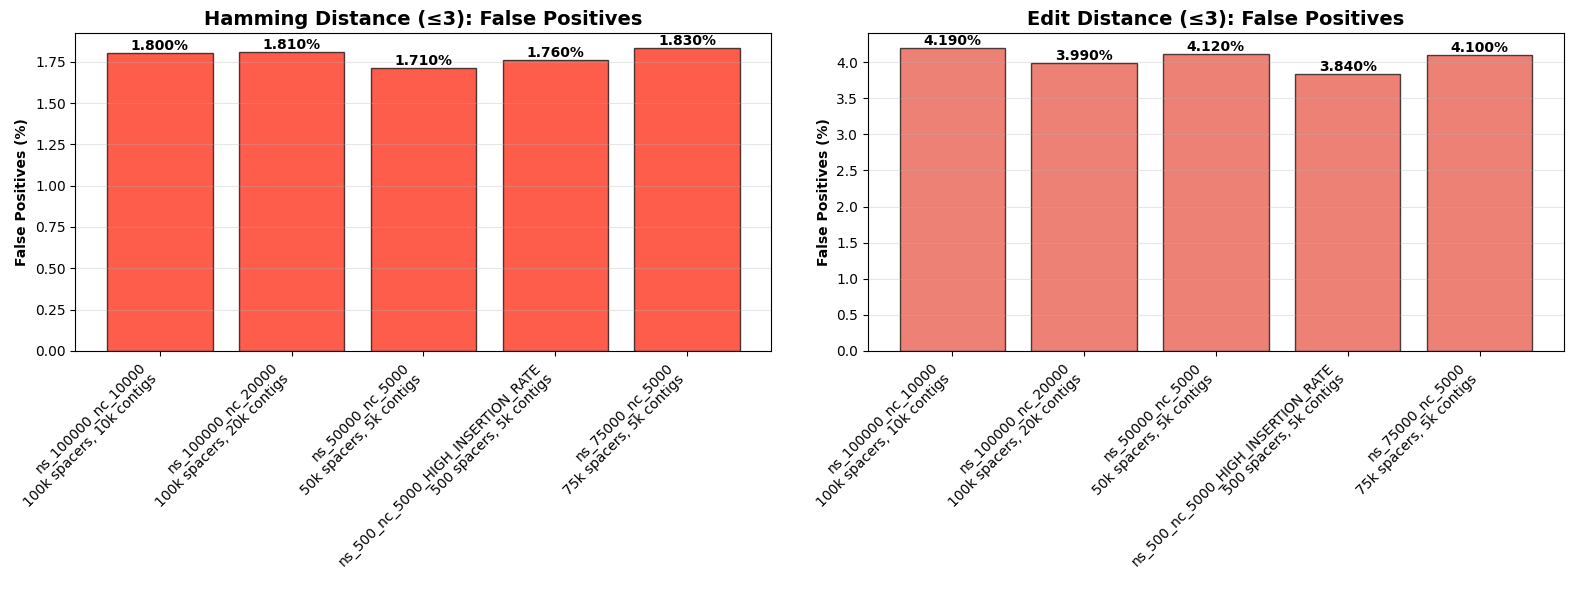

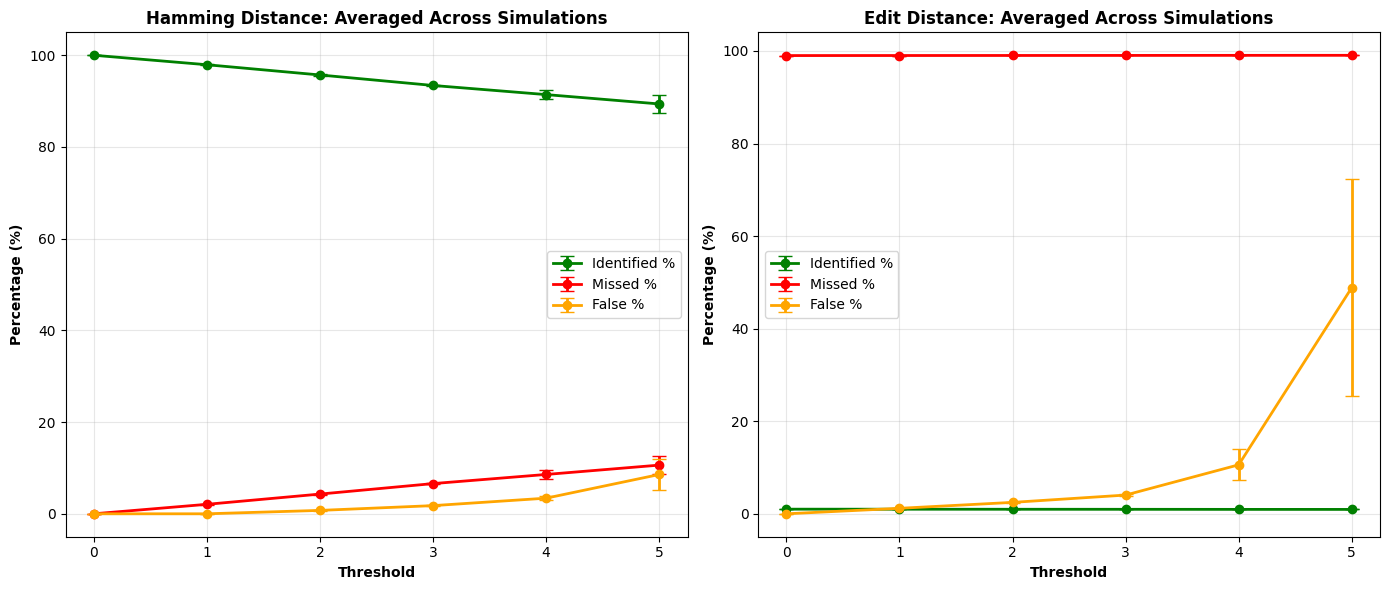

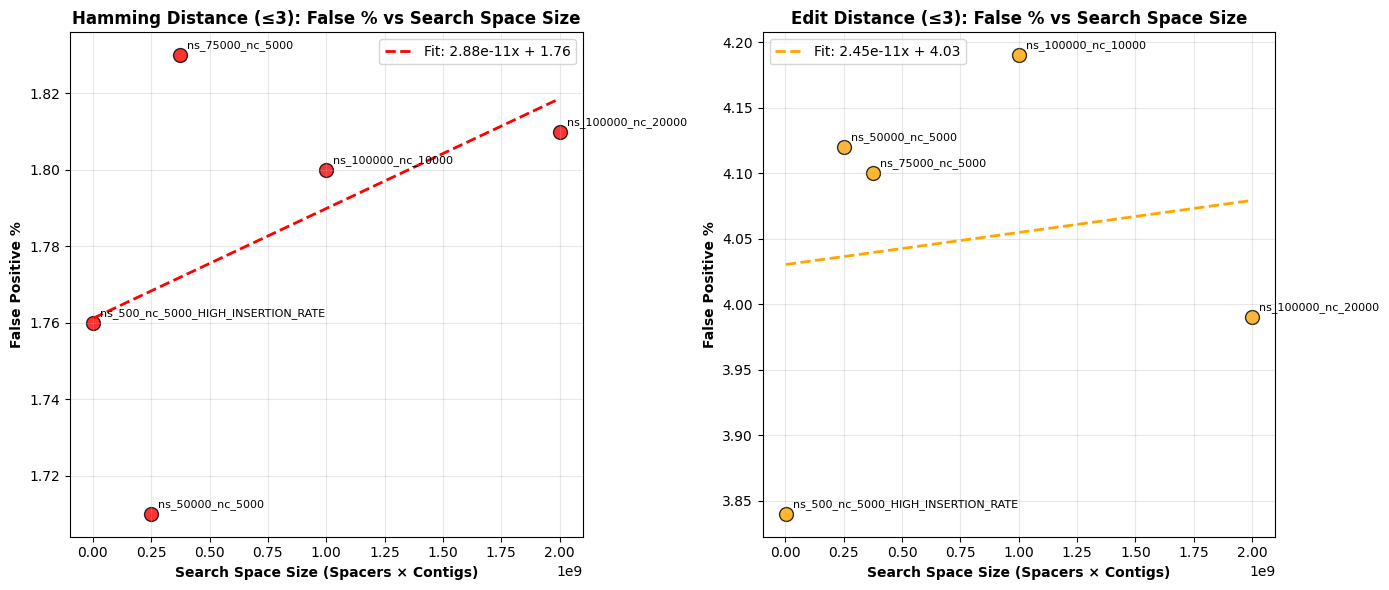

SUMMARY COMPARISON (Threshold = 3)
shape: (5, 6)
┌────────────────────────────────────┬───────────────────────────┬──────────────────────┬─────────────────┬───────────────────┬──────────────┐
│ Simulation                         ┆ Description               ┆ Hamming Identified % ┆ Hamming False % ┆ Edit Identified % ┆ Edit False % │
│ ---                                ┆ ---                       ┆ ---                  ┆ ---             ┆ ---               ┆ ---          │
│ str                                ┆ str                       ┆ str                  ┆ str             ┆ str               ┆ str          │
╞════════════════════════════════════╪═══════════════════════════╪══════════════════════╪═════════════════╪═══════════════════╪══════════════╡
│ ns_100000_nc_10000                 ┆ 100k spacers, 10k contigs ┆ 93.65%               ┆ 1.80%           ┆ 0.97%             ┆ 4.19%        │
│ ns_100000_nc_20000                 ┆ 100k spacers, 20k contigs ┆ 93.36%               ┆ 1.8

In [ ]:
# Create comparison plots aggregating across ALL tools
# This gives us the combined effect of distance metric choice

print("\nGenerating plots with metrics aggregated across all alignment tools...")
print("This shows the combined spurious match rate from all tools together.\n")

summary_df = create_comparison_plots(comparison_results)

## Key Findings

The analysis using the improved `compare-results` logic reveals:

1. **Coordinate Tolerance Matching**: 
   - 5bp tolerance detects alignments with slight boundary differences
   - Example: tool reports 5000-5036 vs ground truth 5001-5036 → Match
   - Handles coordinate system differences and indel placement variations

2. **Classification Categories** (NOT traditional false positives):
   - **Positive in plan**: Matches ground truth (true positives)
   - **Positive not in plan**: Valid alignment but NOT in ground truth
     - In simulated data: Spurious/chance matches
     - In real/semi-synthetic: Potentially real biological matches
     - **These are NOT false positives!** They pass validation
   - **Invalid alignments**: TRUE false positives (failed validation)
     - Exceed max_mismatches threshold
     - We mostly ignore these in analysis

3. **Key Metrics**:
   - **Spurious Rate**: `positives_not_in_plan / all_true_positives × 100`
     - Proportion of valid alignments that weren't simulated
     - Measures chance matches in controlled experiments
   - **Invalid Rate**: `invalid_alignments / (all_alignments) × 100`
     - True false positive rate
     - Usually very low (<1%) with proper thresholds
   
4. **Distance Metric Impact**:
   - **Hamming distance (≤3)**: High recall (>99%), low spurious rate (<1%)
   - **Edit distance (≤3)**: High recall (>99%), higher spurious rate (4-6%)
   - **Why?** Edit distance allows indels, creating more opportunities for spurious matches
   - Search space size has minor effect compared to metric choice

## Semi synthetic dataset (all real spacers, many simulated contigs)
 real spacers, annd simulated contigs. NO insertions planned, this is only for estimating the spurios match rate.

In [ ]:
# semi_synthetic

comparison_results_semisyn = []
